In [20]:
import os
from collections import defaultdict
from itertools import product
from os import listdir
from os.path import isdir, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tbparse import SummaryReader

plt.rcParams["figure.dpi"] = 300

In [21]:
methods = [
    "fixmatch",
    # "fixmatch-ours",
    "fixmatch-bam",
    "fixmatch-mr",
    "freematch",
    # "freematch-ours",
    "freematch-bam",
    "freematch-mr",
]
datasets = ["cifar10"]
seeds = [0]
names = list(
    map(
        lambda x: "P--" + x[0] + "_" + x[1] + "_" + str(x[2]),
        product(methods, datasets, seeds),
    )
)
new_names = []
for name in names:
    if "ours" in name:
        name = name + "_False_0.05"
    else:
        name = name[:-2] + "_True" + name[-2:]
    new_names.append(name)
names = new_names

In [22]:
results = defaultdict(list)
spliter = "Time per iter : "

times = {name: [] for name in names}
df_top1_s = []
df_batch_pl_acc_s = []
df_batch_pl_cov_s = []

for name in names:

    path = join("accumulation", name)
    while isdir(path) and "log.txt" not in listdir(path):
        path = join(path, os.listdir(path)[0])
    tb_path = join(path, "tensorboard")
    log_path = join(path, "log.txt")

    with open(log_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            if not spliter in line:
                continue
            time = float(line.split(spliter)[1])
            times[name].append(time)

    test_top_1_acc = float(lines[-2].split(":")[-1])

    if "ours" in name:
        method, dataset, seed, accu, eps = name[3:].split("_")
    else:
        method, dataset, accu, seed = name[3:].split("_")

    results["method"].append(method)
    results["dataset"].append(dataset)
    results["seed"].append(seed)
    results["test_top_1_acc"].append(test_top_1_acc * 100)

    reader = SummaryReader(tb_path)
    df_tf = reader.scalars

    df_top1 = df_tf[df_tf.tag == "test/top-1-acc"]
    df_top1["method"] = method
    df_top1["seed"] = seed
    df_top1["dataset"] = dataset
    df_top1["accu"] = accu
    df_top1_s.append(df_top1)

    df_batch_pl_acc = df_tf[df_tf.tag == "batch_pl_acc"]
    df_batch_pl_acc["method"] = method
    df_batch_pl_acc["seed"] = seed
    df_batch_pl_acc["dataset"] = dataset
    df_batch_pl_acc["accu"] = accu
    df_batch_pl_acc_s.append(df_batch_pl_acc)

    df_batch_pl_cov = df_tf[df_tf.tag == "batch_pl_cov"]
    df_batch_pl_cov["method"] = method
    df_batch_pl_cov["seed"] = seed
    df_batch_pl_cov["dataset"] = dataset
    df_batch_pl_cov["accu"] = accu
    df_batch_pl_cov_s.append(df_batch_pl_cov)

results_df = pd.DataFrame(results)
df_top1 = pd.concat(df_top1_s)
df_batch_pl_acc = pd.concat(df_batch_pl_acc_s)
df_batch_pl_cov = pd.concat(df_batch_pl_cov_s)

/tmp/ipykernel_2234976/2897154910.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top1["method"] = method
/tmp/ipykernel_2234976/2897154910.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top1["seed"] = seed
/tmp/ipykernel_2234976/2897154910.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [23]:
for name in names:
    print(f"{name} : {np.mean(times[name]):.3f} +/- {np.std(times[name]):.3f}")

P--fixmatch_cifar10_True_0 : 0.208 +/- 0.470
P--fixmatch-bam_cifar10_True_0 : 0.203 +/- 0.439
P--fixmatch-mr_cifar10_True_0 : 0.215 +/- 0.488
P--freematch_cifar10_True_0 : 0.199 +/- 0.415
P--freematch-bam_cifar10_True_0 : 0.132 +/- 0.351
P--freematch-mr_cifar10_True_0 : 0.217 +/- 0.484


In [24]:
results_df[results_df.dataset == "cifar10"].groupby(
    ["method", "dataset"]
).test_top_1_acc.agg(["mean", "std"])

,,mean,std
method,dataset,,
fixmatch,cifar10,68.975,NaN
fixmatch-bam,cifar10,69.400,NaN
fixmatch-mr,cifar10,68.925,NaN
freematch,cifar10,85.675,NaN
freematch-bam,cifar10,87.775,NaN
freematch-mr,cifar10,85.825,NaN


In [25]:
df_top1 = df_top1.iloc[::10]
df_batch_pl_acc = df_batch_pl_acc.iloc[::200]
df_batch_pl_cov = df_batch_pl_cov.iloc[::200]
df_top1.value = df_top1.value * 100
df_batch_pl_acc.value = df_batch_pl_acc.value * 100
df_batch_pl_cov.value = df_batch_pl_cov.value * 100

In [16]:
df_top1.loc[
    (df_top1.method == "fixmatch-ours")
    & (df_top1.seed == "0")
    & (df_top1.step == 24819),
    "step",
] = df_top1.step.max()
df_top1.loc[
    (df_top1.method == "freematch-ours")
    & (df_top1.seed == "0")
    & (df_top1.step == 24819),
    "step",
] = df_top1.step.max()

df_batch_pl_acc.loc[
    (df_batch_pl_acc.method == "fixmatch-ours")
    & (df_batch_pl_acc.seed == "0")
    & (df_batch_pl_acc.step == 24800),
    "step",
] = df_batch_pl_acc.step.max()
df_batch_pl_acc.loc[
    (df_batch_pl_acc.method == "freematch-ours")
    & (df_batch_pl_acc.seed == "0")
    & (df_batch_pl_acc.step == 24800),
    "step",
] = df_batch_pl_acc.step.max()

df_batch_pl_cov.loc[
    (df_batch_pl_cov.method == "fixmatch-ours")
    & (df_batch_pl_cov.seed == "0")
    & (df_batch_pl_cov.step == 24800),
    "step",
] = df_batch_pl_cov.step.max()
df_batch_pl_cov.loc[
    (df_batch_pl_cov.method == "freematch-ours")
    & (df_batch_pl_cov.seed == "0")
    & (df_batch_pl_cov.step == 24800),
    "step",
] = df_batch_pl_cov.step.max()

In [28]:
df_top1.to_parquet(f"df_top1_{datasets[0]}_accuTrue.parquet")
df_batch_pl_acc.to_parquet(f"df_batch_pl_acc_{datasets[0]}_accuTrue.parquet")
df_batch_pl_cov.to_parquet(f"df_batch_pl_cov_{datasets[0]}_accuTrue.parquet")

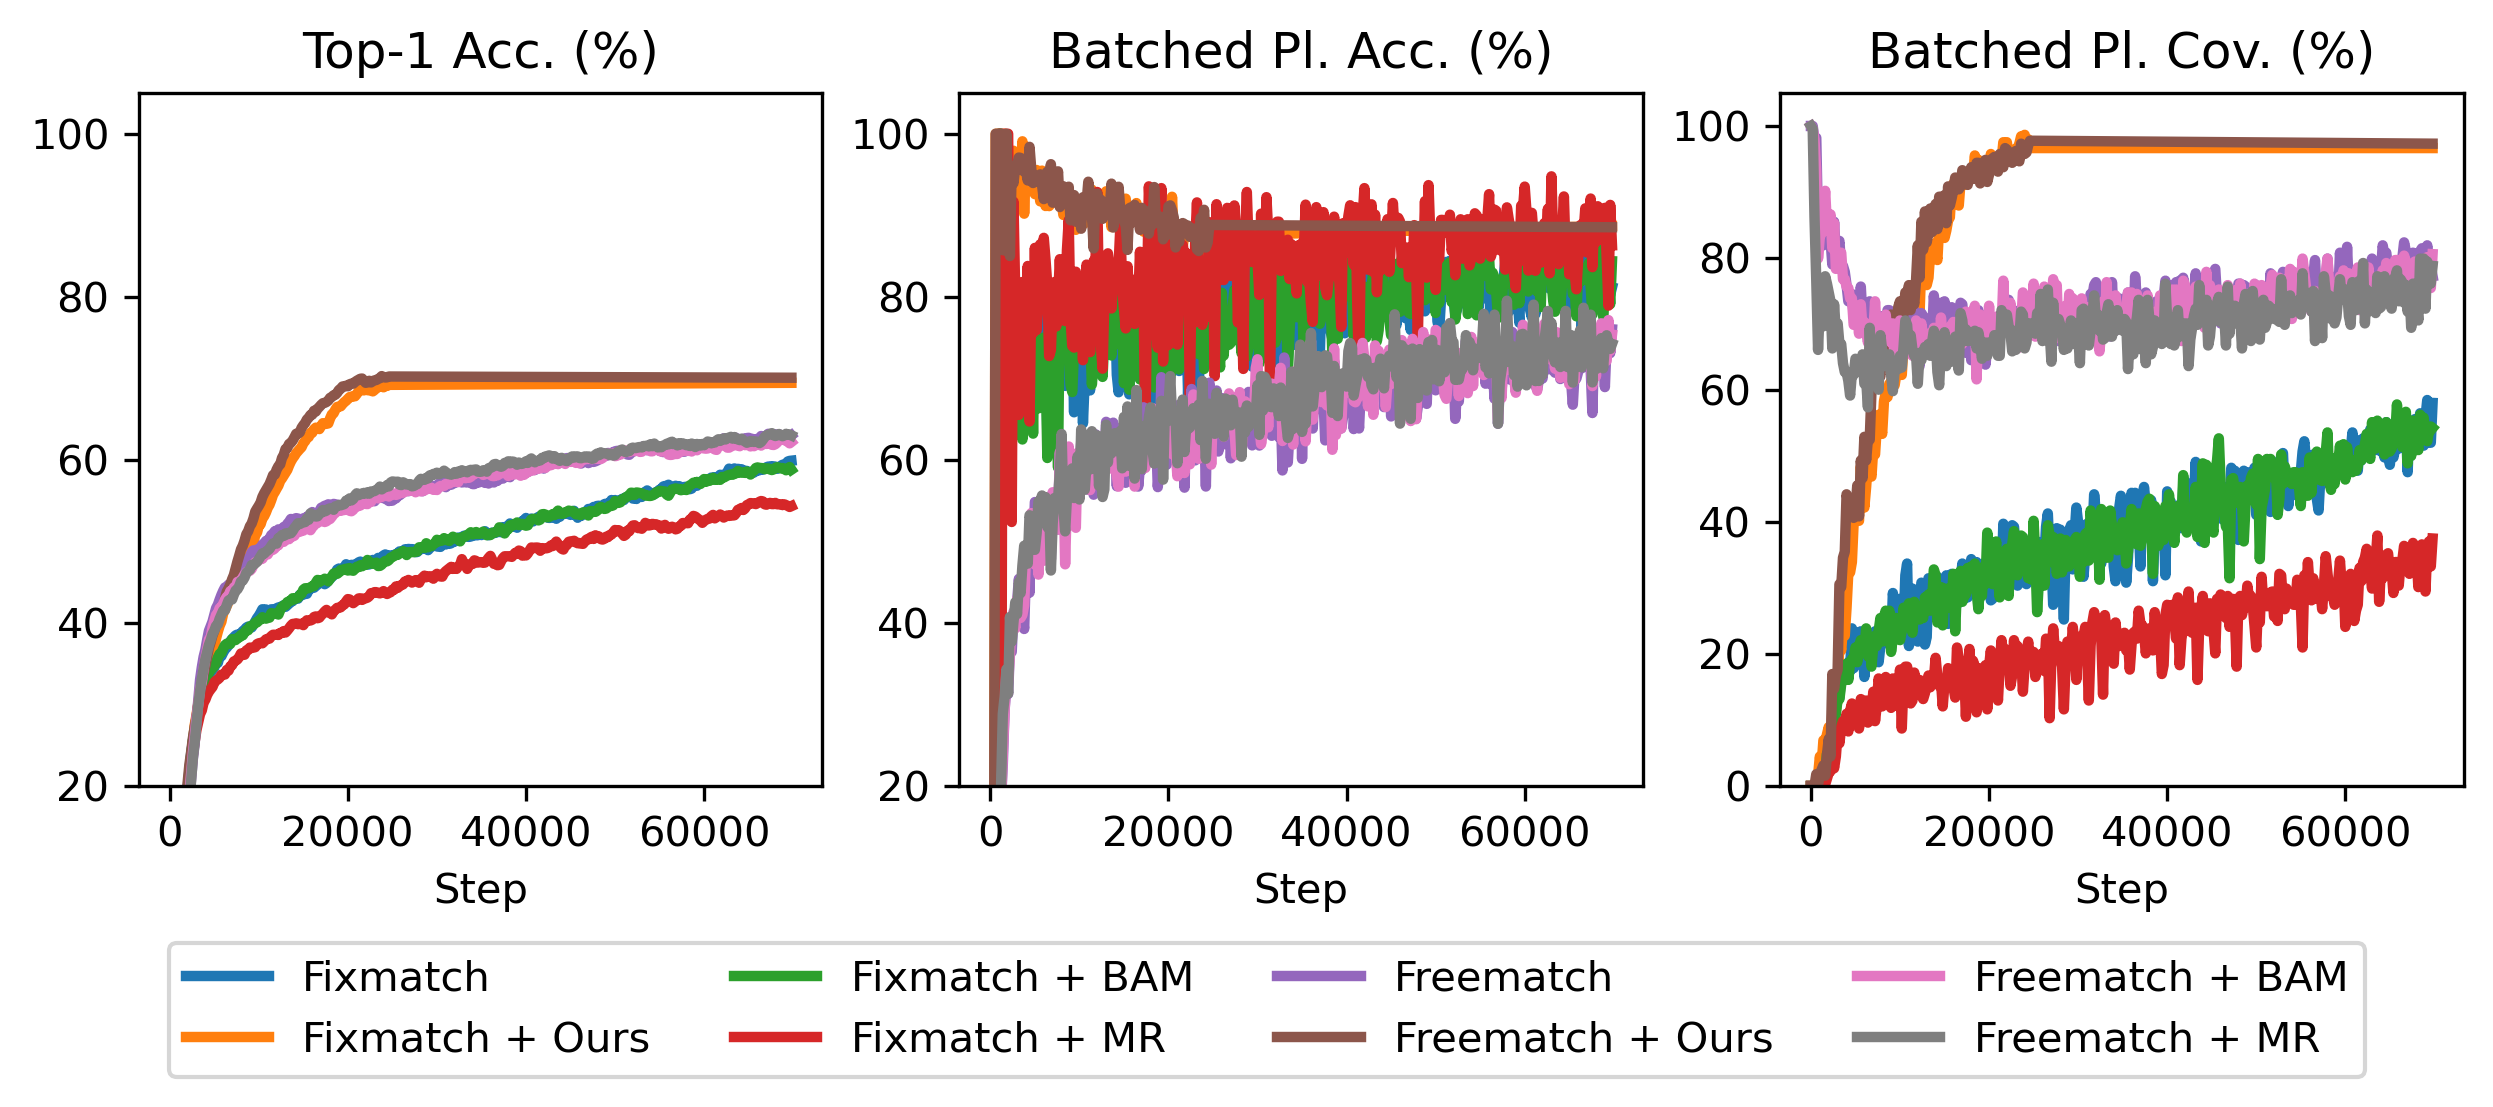

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

sns.lineplot(
    data=df_top1[df_top1.seed == "0"],
    x="step",
    y="value",
    hue="method",
    ax=axes[0],
)
sns.lineplot(
    data=df_batch_pl_acc[df_batch_pl_acc.seed == "0"],
    x="step",
    y="value",
    hue="method",
    ax=axes[1],
)
sns.lineplot(
    data=df_batch_pl_cov[df_batch_pl_cov.seed == "0"],
    x="step",
    y="value",
    hue="method",
    ax=axes[2],
)

axes[0].set_title("Top-1 Acc. (%)")
axes[1].set_title("Batched Pl. Acc. (%)")
axes[2].set_title("Batched Pl. Cov. (%)")
axes[0].set_xlabel("Step")
axes[1].set_xlabel("Step")
axes[2].set_xlabel("Step")
axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
axes[0].set_ylim(20, 105)
axes[1].set_ylim(20, 105)
if datasets[0] == "cifar100":
    axes[2].set_ylim(0, 105)
else:
    axes[2].set_ylim(20, 105)

axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[0].legend(loc="lower center", bbox_to_anchor=(1.65, -0.45), ncol=4)

for ax in axes:
    for line in ax.get_lines():
        line.set_linewidth(2.5)

        rename_map = {
            "fixmatch": "Fixmatch",
            "fixmatch-ours": "Fixmatch + Ours",
            "fixmatch-bam": "Fixmatch + BAM",
            "fixmatch-mr": "Fixmatch + MR",
            "freematch": "Freematch",
            "freematch-ours": "Freematch + Ours",
            "freematch-bam": "Freematch + BAM",
            "freematch-mr": "Freematch + MR",
        }

        handles, labels = axes[0].get_legend_handles_labels()
        new_labels = [rename_map[label] for label in labels]
        axes[0].legend(
            handles,
            new_labels,
            loc="lower center",
            bbox_to_anchor=(1.65, -0.45),
            ncol=4,
        )

plt.show()
fig.savefig(f"{datasets[0]}.png", bbox_inches="tight")